# Determining the age of a buyer from a photo

## Project decription

The Khleb-Sol supermarket chain is implementing a computer vision system for processing photos of buyers. Photo recording in the checkout area will help determine the age of customers to:

1. Analyze purchases and offer products that may interest buyers of this age group;
2. Monitor the integrity of cashiers when selling alcohol.

Build a model that will determine the approximate age of a person from a photo. You have a set of photos of people with ages at your disposal.

## Exploratory data analysis

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data overview

####  CSV-file

##### Reading the dataset

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


We have a dataset containing 7591 records. The dataset contains the following features:
* `file_name` - image name, data type `object`
* `real_age` - age of the person in the image, target feature, data type `int64`

##### Check for omissions

In [5]:
# Check for any omissions
df.isna().sum()

file_name    0
real_age     0
dtype: int64

##### Visualization of the distribution of the target feature

In [6]:
target = df['real_age']
target_grouped = target.value_counts().sort_index()

In [7]:
target_grouped

1      149
2       88
3       25
4      101
5       87
      ... 
94       5
95       2
96       2
97       1
100      1
Name: real_age, Length: 97, dtype: int64

After grouping, we see that our dataset contains 97 age categories ranging from 1 year to 100 years.

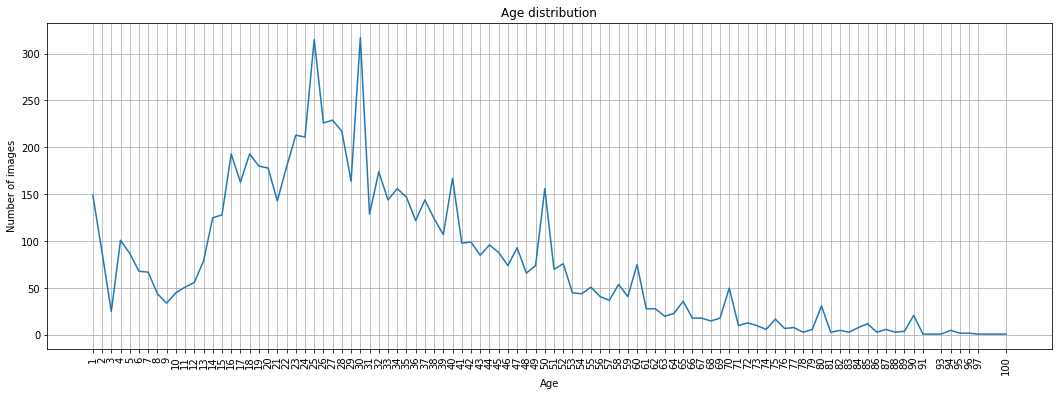

In [8]:
# plot the distribution of the target feature in the dataset
x = list(target_grouped.index)
y = list(target_grouped.array)

plt.figure(figsize=(18,6))
plt.title('Age distribution')
plt.grid(visible=True)
plt.xticks(x, rotation=90)
plt.xlabel('Age')
plt.ylabel('Number of images')
plt.plot(x, y)
plt.show()

The graph shows the distribution of images by age.

Our dataset contains a fairly large group of images of children aged 1 year. Up to the age of 9, the number of images is uneven. The number of images of children aged 3 and 9 is the lowest among all images of people up to the age of 61.

After age 9, an upward trend begins. The group of people aged 16 to 21 is relatively well represented. This will help us in our task of controlling alcohol sales. As age increases, the number of images increases and reaches two peaks at ages 25 and 30.

After 30 years age of, a downward trend in the number of images begins, with several positive peaks at ages 40, 50, 60, 70, 80, and 90. The graph clearly shows that people aged 92, 98, and 99 are not represented.

####  Images

##### Reading images and preparing samples

Let's prepare training and validation samples.

In [9]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

In [10]:
train_datagen_flow = train_datagen.flow_from_dataframe(
    df,
    '/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345)

val_datagen_flow = validation_datagen.flow_from_dataframe(
    df,
    '/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


##### Sample images

Let's output 16 images from the first training batch.

In [11]:
X_train, y_train = next(train_datagen_flow)

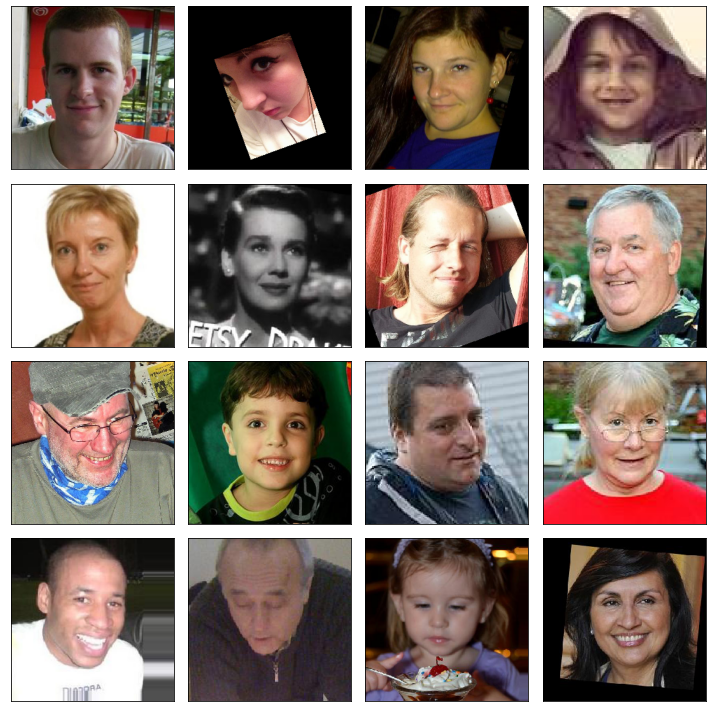

In [12]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

As we can see, the images of people have a wide range of image quality, color, shooting angle, and lighting. Some images are initially augmented and have a slight rotation. This is probably done to align the faces along the axes. At the same time, the area occupied by the faces in the images looks the same.

### Conclusion on EDA

As a result of studying the dataset, we can draw the following conclusions:

1. We have 7591 images of people of different ages at our disposal.

2. The age distribution in the dataset is uneven, with several peaks and dips.
3. The quality of the images varies. But the area occupied by people's faces in the photo is approximately the same.

As a result of the research, we can assume that in most cases the model will cope with the task.

## Model training

Move the model training code and its output to the screen here.

(The code in this section runs in a separate GPU simulator, so it is not formatted as a cell with code, but as code in a text cell)

```python
import pandas as pd

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator



optimizer = Adam(lr=0.0001)

df = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        df,
        '/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    validation_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    val_datagen_flow = validation_datagen.flow_from_dataframe(
        df,
        '/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return val_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(256, 256, 3),
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=50,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```
Train for 356 steps, validate for 119 steps

Epoch 1/50

2024-07-28 21:02:10.091953: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2024-07-28 21:02:10.415445: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 56s - loss: 192.1637 - mae: 10.1167 - val_loss: 770.4723 - val_mae: 22.8131

Epoch 2/50

356/356 - 44s - loss: 69.3708 - mae: 6.3658 - val_loss: 150.7330 - val_mae: 9.3450

Epoch 3/50

356/356 - 44s - loss: 38.8716 - mae: 4.7967 - val_loss: 71.4856 - val_mae: 6.4401

Epoch 4/50

356/356 - 44s - loss: 25.8185 - mae: 3.9348 - val_loss: 76.3923 - val_mae: 6.5294

Epoch 5/50

356/356 - 45s - loss: 19.1204 - mae: 3.3371 - val_loss: 88.0852 - val_mae: 7.0671

Epoch 6/50

356/356 - 44s - loss: 14.0370 - mae: 2.8697 - val_loss: 65.0547 - val_mae: 6.1342

Epoch 7/50

356/356 - 44s - loss: 12.4168 - mae: 2.6848 - val_loss: 64.4599 - val_mae: 6.0657

Epoch 8/50

356/356 - 45s - loss: 11.2880 - mae: 2.5401 - val_loss: 63.0294 - val_mae: 5.9451

Epoch 9/50

356/356 - 44s - loss: 11.3323 - mae: 2.5368 - val_loss: 69.2517 - val_mae: 6.2108

Epoch 10/50

356/356 - 44s - loss: 10.0623 - mae: 2.4161 - val_loss: 65.3052 - val_mae: 6.2677

Epoch 11/50

356/356 - 44s - loss: 8.9979 - mae: 2.2707 - val_loss: 64.3076 - val_mae: 6.0719

Epoch 12/50

356/356 - 44s - loss: 8.3197 - mae: 2.1897 - val_loss: 65.7967 - val_mae: 6.2642

Epoch 13/50

356/356 - 44s - loss: 8.7558 - mae: 2.2479 - val_loss: 65.1966 - val_mae: 6.1041

Epoch 14/50

356/356 - 44s - loss: 9.0030 - mae: 2.2592 - val_loss: 75.3185 - val_mae: 6.6390

Epoch 15/50

356/356 - 44s - loss: 8.8852 - mae: 2.2311 - val_loss: 61.6306 - val_mae: 6.0360

Epoch 16/50

356/356 - 44s - loss: 8.1338 - mae: 2.1342 - val_loss: 62.1120 - val_mae: 5.8892

Epoch 17/50

356/356 - 44s - loss: 7.7846 - mae: 2.1174 - val_loss: 61.1712 - val_mae: 5.9045

Epoch 18/50

356/356 - 44s - loss: 7.3703 - mae: 2.0687 - val_loss: 65.6571 - val_mae: 6.2929

Epoch 19/50

356/356 - 44s - loss: 7.3999 - mae: 2.0152 - val_loss: 60.6852 - val_mae: 5.8078

Epoch 20/50

356/356 - 45s - loss: 6.4143 - mae: 1.9350 - val_loss: 59.3502 - val_mae: 5.8095

Epoch 21/50

356/356 - 45s - loss: 6.0757 - mae: 1.8675 - val_loss: 65.1714 - val_mae: 5.9775

Epoch 22/50

356/356 - 44s - loss: 6.1683 - mae: 1.8808 - val_loss: 61.9747 - val_mae: 5.8271

Epoch 23/50

356/356 - 45s - loss: 6.2678 - mae: 1.8847 - val_loss: 58.1537 - val_mae: 5.8586

Epoch 24/50

356/356 - 44s - loss: 5.9937 - mae: 1.8522 - val_loss: 59.9560 - val_mae: 5.8532

Epoch 25/50

356/356 - 45s - loss: 6.0022 - mae: 1.8605 - val_loss: 66.5372 - val_mae: 6.2042

Epoch 26/50

356/356 - 44s - loss: 5.1770 - mae: 1.7214 - val_loss: 58.0007 - val_mae: 5.6625

Epoch 27/50

356/356 - 44s - loss: 4.4164 - mae: 1.5760 - val_loss: 57.9896 - val_mae: 5.6776

Epoch 28/50

356/356 - 45s - loss: 4.1423 - mae: 1.5489 - val_loss: 59.8456 - val_mae: 5.7586

Epoch 29/50

356/356 - 44s - loss: 4.0883 - mae: 1.5195 - val_loss: 57.8757 - val_mae: 5.6588

Epoch 30/50

356/356 - 44s - loss: 3.9971 - mae: 1.5147 - val_loss: 67.7697 - val_mae: 6.3778

Epoch 31/50

356/356 - 44s - loss: 4.0578 - mae: 1.5235 - val_loss: 59.5408 - val_mae: 5.9445

Epoch 32/50

356/356 - 45s - loss: 4.2131 - mae: 1.5617 - val_loss: 60.5703 - val_mae: 5.7570

Epoch 33/50

356/356 - 44s - loss: 4.3907 - mae: 1.5817 - val_loss: 60.4631 - val_mae: 5.9071

Epoch 34/50

356/356 - 44s - loss: 4.5726 - mae: 1.6057 - val_loss: 63.4073 - val_mae: 5.8447

Epoch 35/50

356/356 - 44s - loss: 4.4625 - mae: 1.5941 - val_loss: 58.3577 - val_mae: 5.7118

Epoch 36/50

356/356 - 44s - loss: 4.0641 - mae: 1.4971 - val_loss: 64.9009 - val_mae: 6.1524

Epoch 37/50

356/356 - 44s - loss: 3.4588 - mae: 1.3862 - val_loss: 58.4386 - val_mae: 5.8557

Epoch 38/50

356/356 - 44s - loss: 3.0422 - mae: 1.3102 - val_loss: 60.2796 - val_mae: 5.8455

Epoch 39/50

356/356 - 44s - loss: 3.3537 - mae: 1.3607 - val_loss: 72.9519 - val_mae: 6.5907

Epoch 40/50

356/356 - 45s - loss: 8.2402 - mae: 2.0636 - val_loss: 74.2298 - val_mae: 6.4653

Epoch 41/50

356/356 - 44s - loss: 8.5356 - mae: 2.1400 - val_loss: 67.5740 - val_mae: 6.2567

Epoch 42/50

356/356 - 45s - loss: 3.5618 - mae: 1.3987 - val_loss: 60.6038 - val_mae: 5.9330

Epoch 43/50

356/356 - 46s - loss: 1.3969 - mae: 0.8746 - val_loss: 57.3039 - val_mae: 5.6084

Epoch 44/50

356/356 - 44s - loss: 0.7329 - mae: 0.6367 - val_loss: 57.4181 - val_mae: 5.6146

Epoch 45/50

356/356 - 44s - loss: 0.6081 - mae: 0.5701 - val_loss: 56.5282 - val_mae: 5.6499

Epoch 46/50

356/356 - 44s - loss: 0.7771 - mae: 0.6397 - val_loss: 57.6310 - val_mae: 5.6356

Epoch 47/50

356/356 - 44s - loss: 1.2191 - mae: 0.8150 - val_loss: 58.8274 - val_mae: 5.6883

Epoch 48/50

356/356 - 44s - loss: 2.3536 - mae: 1.1394 - val_loss: 57.7683 - val_mae: 5.6700

Epoch 49/50

356/356 - 44s - loss: 3.5427 - mae: 1.3993 - val_loss: 58.9736 - val_mae: 5.8197

Epoch 50/50

356/356 - 44s - loss: 3.8738 - mae: 1.4860 - val_loss: 63.7104 - val_mae: 5.9564

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

119/119 - 11s - loss: 63.7104 - mae: 5.9564

Test MAE: 5.9564
```

## Analysis of the trained model

We trained the ResNet50 model and achieved the target MAE metric on the test equal to 5.9564. This is below the required value of MAE < 8 and below the "excellent" value of MAE < 7.

The last layers of the model were written manually. Additional training of the main ResNet50 model was used. The MSE function was used as a loss function. The Adam algorithm with a learning rate of 0.0001 was used as an optimizer.

The model was trained for 50 epochs, and the target metric was achieved already on the 3rd epoch. First of all, this was achieved by reducing the learning rate of the Adam optimizer to 0.0001. Using the MSE function as a loss function also had a positive effect.

The target metric was achieved, and the task was completed.

The resulting model will help in solving the problems set by the business. Namely:
1. Analyze purchases and offer products that may be of interest to buyers of this age group;
2. Monitor the integrity of cashiers when selling alcohol.